Drone1 Shape: (17204, 79)
   S.No  setpoint_raw-global_Time  setpoint_raw-global_header.seq  \
0     0              1.729405e+09                               1   
1     1              1.729405e+09                               2   
2     2              1.729405e+09                               3   
3     3              1.729405e+09                               4   
4     4              1.729405e+09                               5   

   setpoint_raw-global_header.stamp.secs  setpoint_raw-global_latitude  \
0                                      0                      33.69785   
1                                      0                      33.69785   
2                                      0                      33.69785   
3                                      0                      33.69785   
4                                      0                      33.69785   

   setpoint_raw-global_longitude  setpoint_raw-global_altitude  battery_Time  \
0                      73.016496  

/tmp/ipython-input-633725578.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_clean[numeric_cols] = all_data_clean[numeric_cols].fillna(all_data_clean[numeric_cols].median())


Cleaned dataset saved as 'drone_data_cleaned.csv'


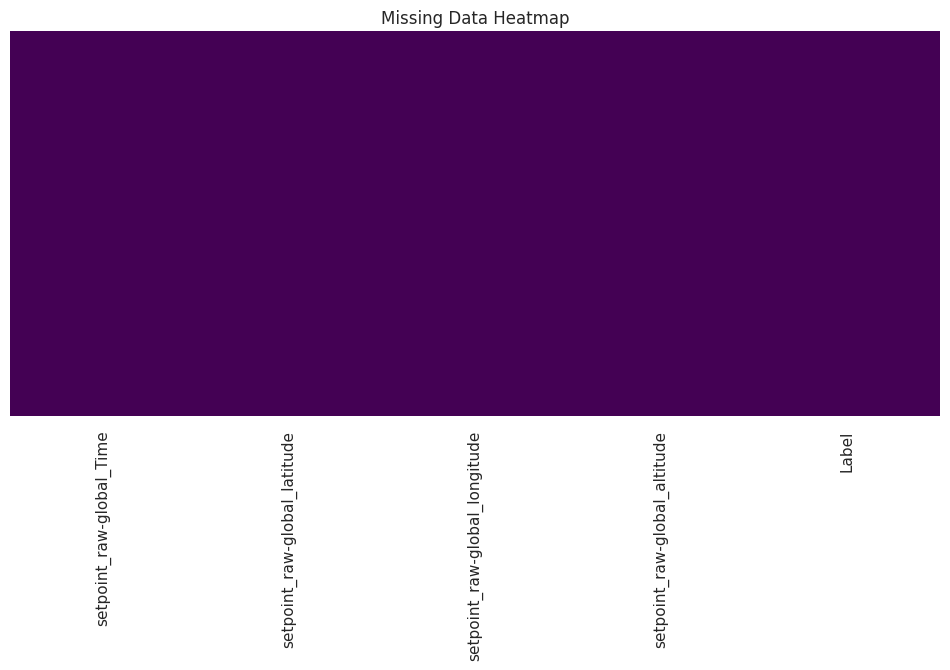

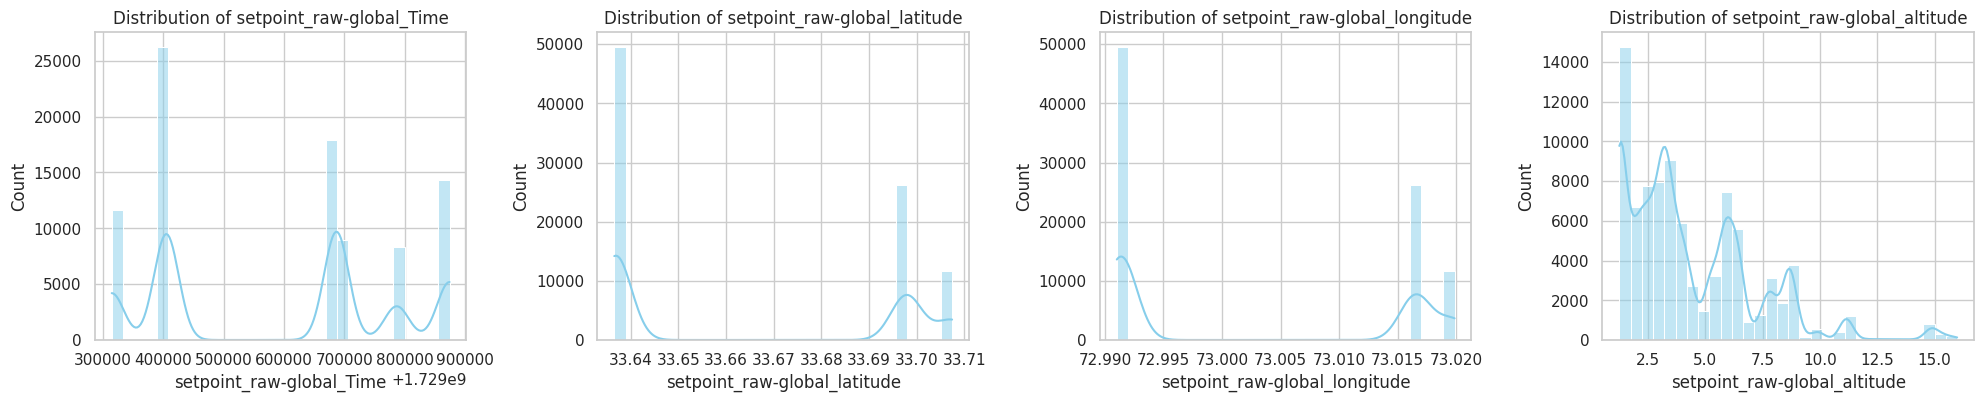

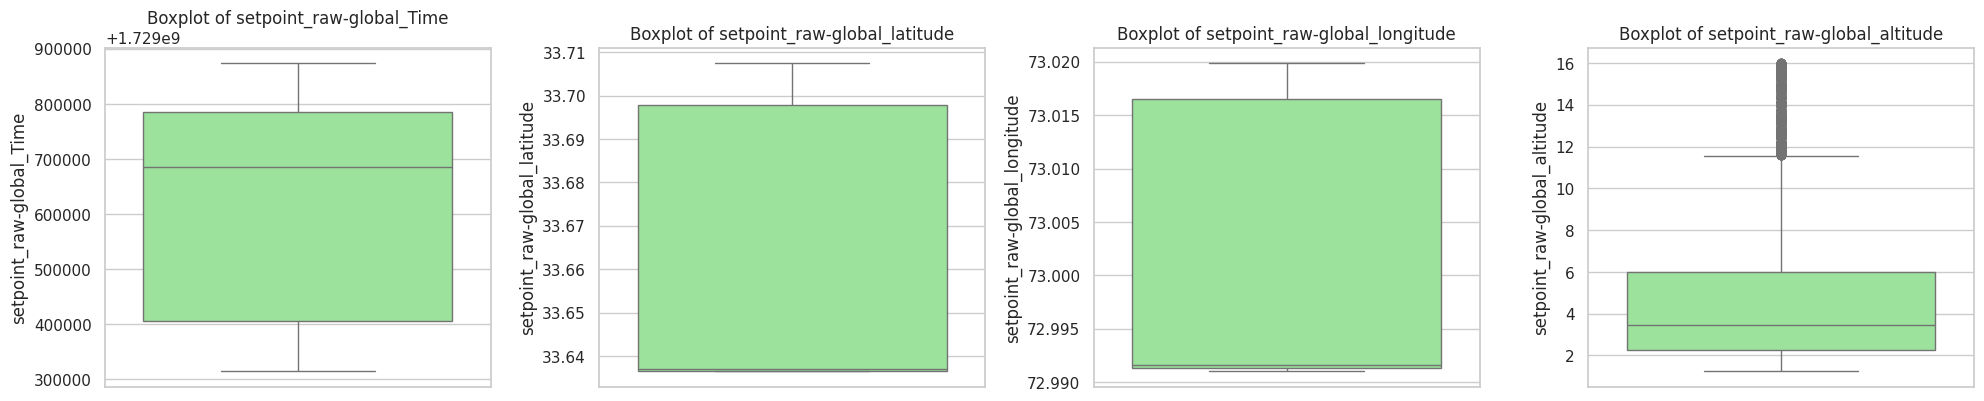

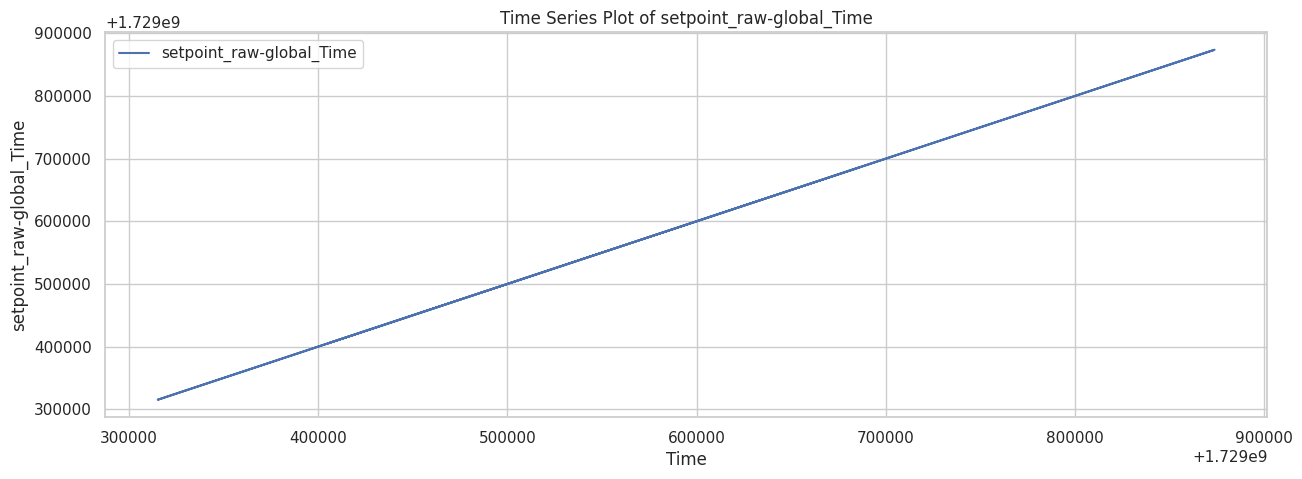

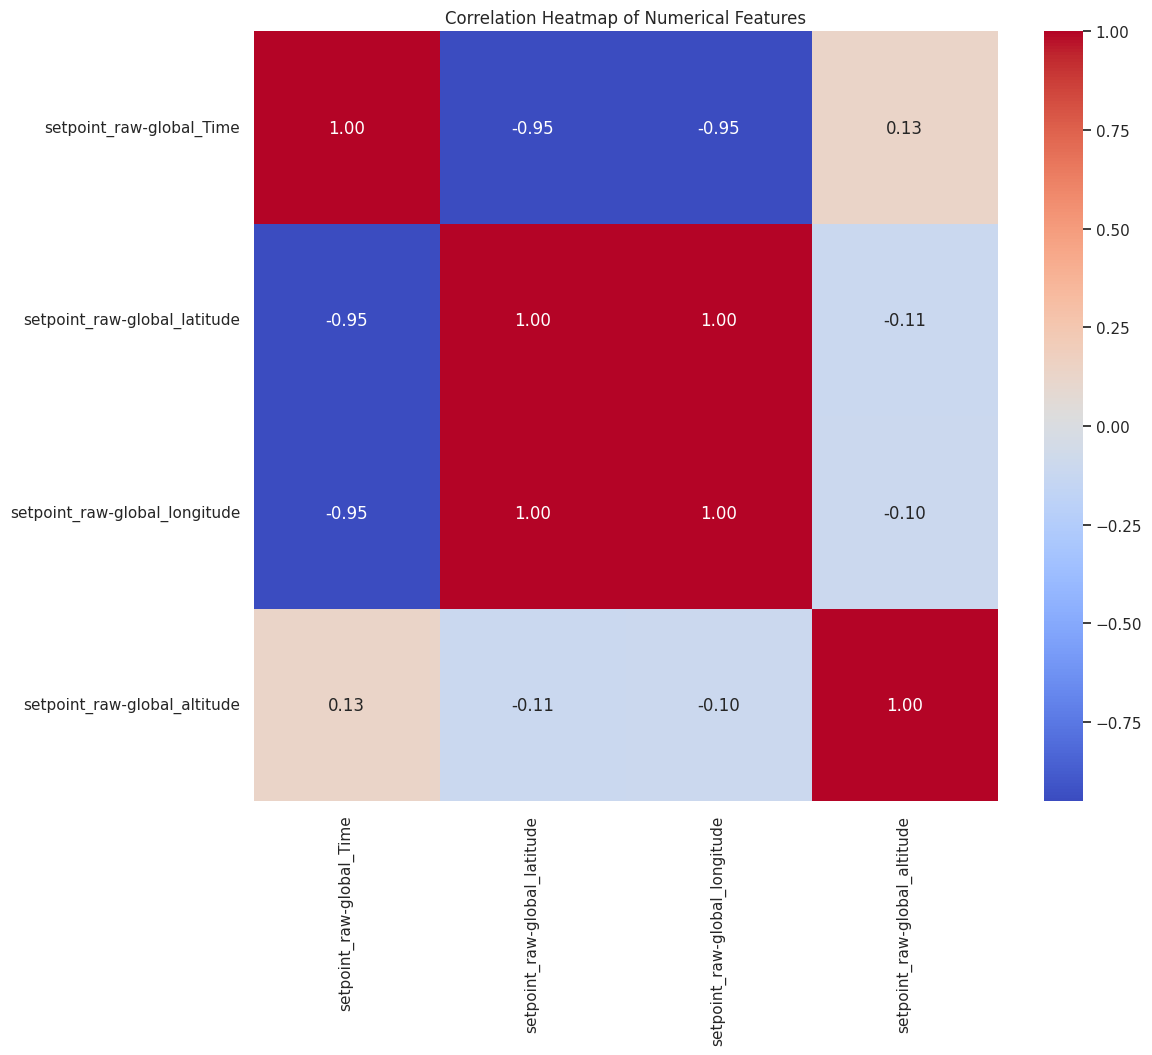

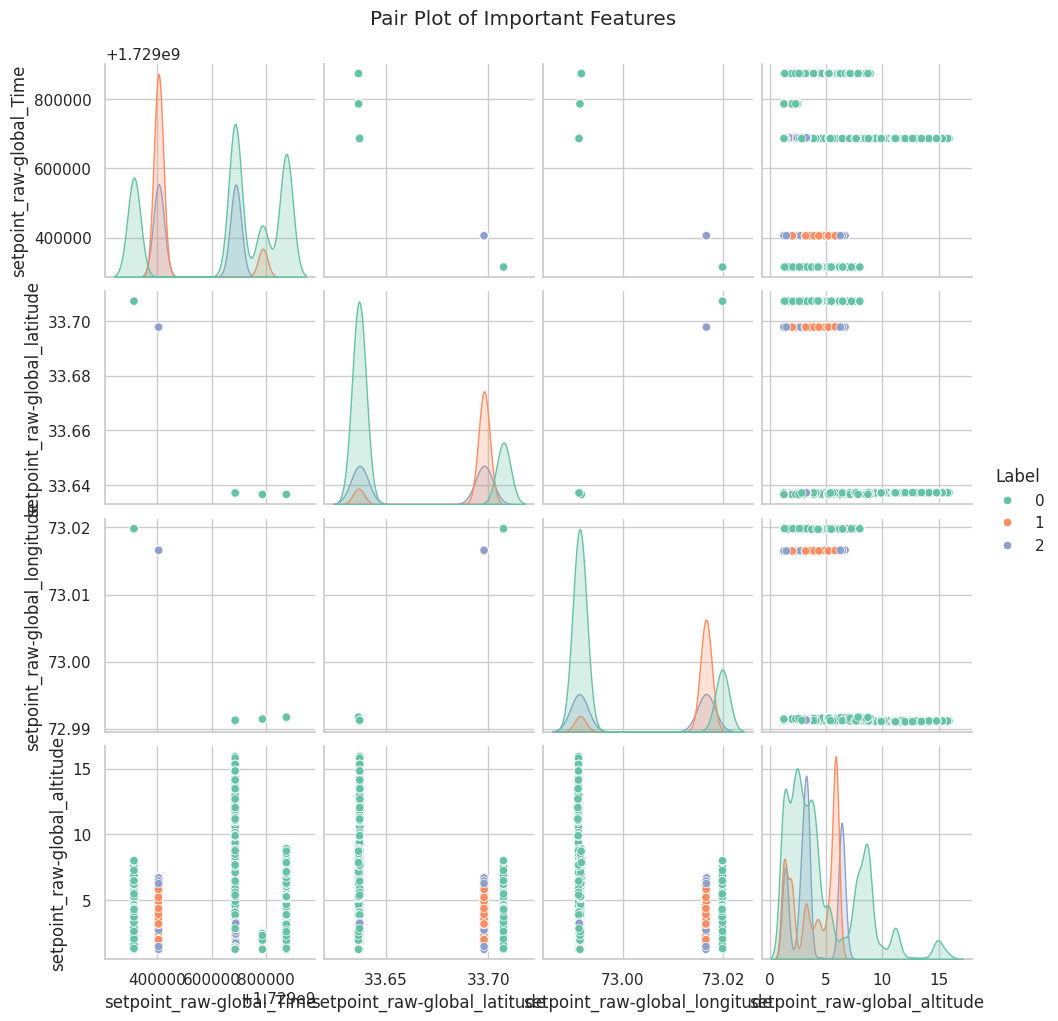

/tmp/ipython-input-633725578.py:134: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=all_data_clean, palette='Set1')


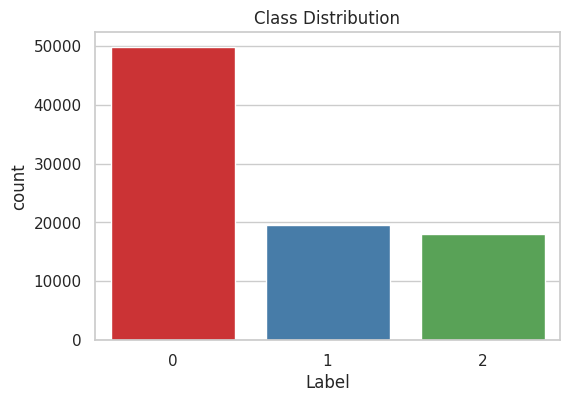

Class counts:
 Label
0    49800
1    19587
2    18030
Name: count, dtype: int64


/tmp/ipython-input-633725578.py:147: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[:20], y=importances[:20].index, palette='viridis')


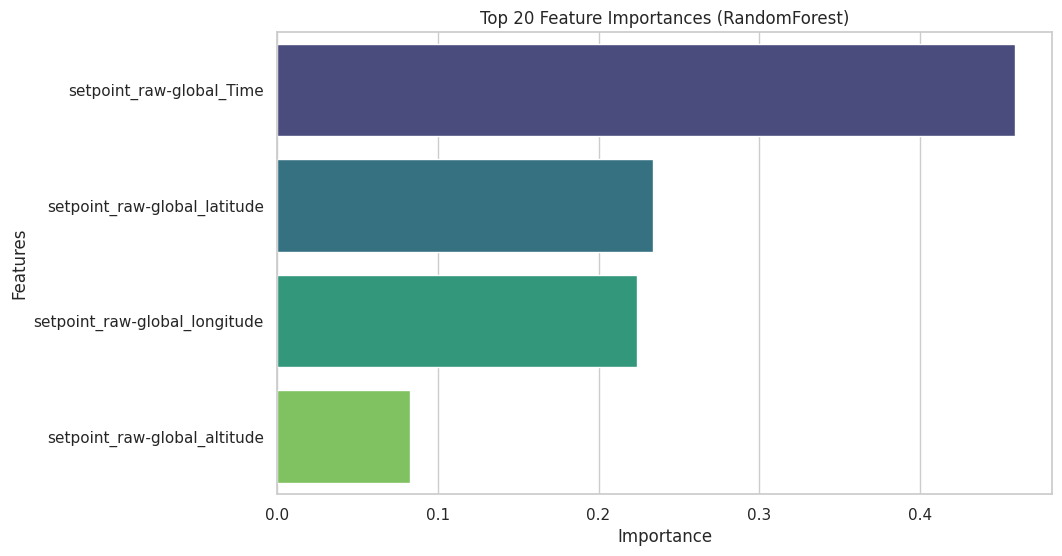

Final preprocessed dataset saved as 'drone_data_preprocessed.csv'. Ready for model training.


In [6]:
# Step 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Set plot style
sns.set(style="whitegrid")

# Step 2: Load CSV files from sample_data
dos1 = pd.read_csv('/content/sample_data/Dos1.csv')
dos2 = pd.read_csv('/content/sample_data/Dos2.csv')
malfunction1 = pd.read_csv('/content/sample_data/Malfunction1.csv')
malfunction2 = pd.read_csv('/content/sample_data/Malfunction2.csv')
normal1 = pd.read_csv('/content/sample_data/Normal1.csv')
normal2 = pd.read_csv('/content/sample_data/Normal2.csv')
normal3 = pd.read_csv('/content/sample_data/Normal3.csv')
normal4 = pd.read_csv('/content/sample_data/Normal4.csv')


# Step 3: Quick inspection
print("Drone1 Shape:", dos1.shape)
print(dos1.head())
print("\nMalfunction1 Shape:", malfunction1.shape)
print(malfunction1.head())
print("\nNormal1 Shape:", normal1.shape)
print(normal1.head())

# Step 4: Combine similar classes
dos_drones = pd.concat([dos1, dos2], ignore_index=True)
malfunction_drones = pd.concat([malfunction1, malfunction2], ignore_index=True)
normal_flight = pd.concat([normal1, normal2, normal3, normal4], ignore_index=True)

# Step 5: Assign labels
# 0 = Normal, 1 = DoS Attack, 2 = Malfunction
normal_flight['Label'] = 0
dos_drones['Label'] = 1
malfunction_drones['Label'] = 2

# Step 6: Combine all datasets into a single DataFrame
all_data = pd.concat([normal_flight, dos_drones, malfunction_drones], ignore_index=True)
print("Combined Dataset Shape:", all_data.shape)
print(all_data['Label'].value_counts())

# Step 7:Handle missing values
# Drop columns with >50% missing
# Fill remaining numeric missing values with median
missing_before = all_data.isnull().sum().sum()
all_data_clean = all_data.loc[:, all_data.isnull().mean() < 0.5]
numeric_cols = all_data_clean.select_dtypes(include=np.number).columns
all_data_clean[numeric_cols] = all_data_clean[numeric_cols].fillna(all_data_clean[numeric_cols].median())
missing_after = all_data_clean.isnull().sum().sum()
print(f"Total missing values removed: {missing_before - missing_after}")

# Step 8: Drop irrelevant columns (optional, like indices or timestamps)
irrelevant_cols = ['S.No', 'setpoint_raw-global_header.seq',
                   'setpoint_raw-global_header.stamp.secs']  # update as needed
all_data_clean = all_data_clean.drop(columns=[col for col in irrelevant_cols if col in all_data_clean.columns])

# Step 9: Shuffle dataset
all_data_clean = shuffle(all_data_clean, random_state=42)

# Step 10: Save cleaned dataset
all_data_clean.to_csv('/content/sample_data/drone_data_cleaned.csv', index=False)
print("Cleaned dataset saved as 'drone_data_cleaned.csv'")

# Step 11: Visualizations

# Missing data heatmap
plt.figure(figsize=(12,5))
sns.heatmap(all_data_clean.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()

# Missing values bar chart
missing_counts = all_data_clean.isnull().sum()
missing_counts = missing_counts[missing_counts > 0]
if len(missing_counts) > 0:
    plt.figure(figsize=(10,5))
    missing_counts.plot(kind='bar', color='tomato')
    plt.title("Missing Values Count per Feature")
    plt.ylabel("Count")
    plt.show()

# Distribution plots (histograms/KDE) for key numerical features
numerical_features = all_data_clean.select_dtypes(include=np.number).columns.tolist()
numerical_features.remove('Label') if 'Label' in numerical_features else None

plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_features[:16]):  # first 16 features
    plt.subplot(4,4,i+1)
    sns.histplot(all_data_clean[col], kde=True, color='skyblue', bins=30)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

# Box plots for outlier detection
plt.figure(figsize=(20,15))
for i, col in enumerate(numerical_features[:16]):
    plt.subplot(4,4,i+1)
    sns.boxplot(y=all_data_clean[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

# Time series plot (if temporal analysis relevant)
if 'setpoint_raw-global_Time' in all_data_clean.columns:
    plt.figure(figsize=(15,5))
    plt.plot(all_data_clean['setpoint_raw-global_Time'], all_data_clean[numerical_features[0]], label=numerical_features[0])
    plt.xlabel("Time")
    plt.ylabel(numerical_features[0])
    plt.title(f"Time Series Plot of {numerical_features[0]}")
    plt.legend()
    plt.show()

# Correlation heatmap
plt.figure(figsize=(12,10))
corr_matrix = all_data_clean[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# Pair plot (top 5 features)
top_features = numerical_features[:5]
sns.pairplot(all_data_clean, vars=top_features, hue='Label', palette='Set2', diag_kind='kde')
plt.suptitle("Pair Plot of Important Features", y=1.02)
plt.show()

# Class distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Label', data=all_data_clean, palette='Set1')
plt.title("Class Distribution")
plt.show()
print("Class counts:\n", all_data_clean['Label'].value_counts())

# Feature importance using RandomForest
X = all_data_clean.drop('Label', axis=1)
y = all_data_clean['Label']
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=importances[:20], y=importances[:20].index, palette='viridis')
plt.title("Top 20 Feature Importances (RandomForest)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# Step 12 Deliverable
all_data_clean.to_csv('/content/sample_data/drone_data_preprocessed.csv', index=False)
print("Final preprocessed dataset saved as 'drone_data_preprocessed.csv'. Ready for model training.")